## Image classification on CIFAR-10 dataset

- `CIFAR: Canadian Institute For Advanced Research`

### Import libraries 😌

In [1]:
import numpy as np
import torch
import torchvision
from torchvision.transforms import v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Create transforms which will be applied to images

In [2]:
transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5,), (0.5,)),
    ]
)

### get dataset & pass it into `DataLoader`

In [3]:
# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10(
    "./data", train=True, transform=transforms, download=True
)
validation_set = torchvision.datasets.CIFAR10(
    "./data", train=False, transform=transforms, download=True
)

# Class labels
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False
)
print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


### Visualize dataset

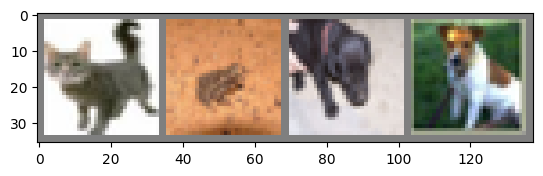

cat   frog  dog   dog  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # un-normalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(training_loader)
images, labels = next(data_iter)
batch_size = 4

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [5]:
print(f"{type(images)=}, {type(images[0])=}")
print(f"{images.shape=}, {images[0].shape=}")

type(images)=<class 'torch.Tensor'>, type(images[0])=<class 'torch.Tensor'>
images.shape=torch.Size([4, 3, 32, 32]), images[0].shape=torch.Size([3, 32, 32])


### Create model

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = Net().to(device=device)

### Define `loss function` & `optimizer`

In [12]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

### Train the network

In [13]:
def train_one_epoch(epoch_index):
    running_loss = 0.0
    last_loss = 0.0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # if using GPU, load inputs & labels in the same GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print("  batch {} loss: {}".format(i + 1, last_loss))
            running_loss = 0.0

    return last_loss

In [14]:
# Initializing in a separate cell so we can easily add more epochs to the same run
epoch_number = 0

EPOCHS = 10

best_v_loss = 1_000_000.0

print(f"model will be using {device =}")

for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    running_v_loss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, v_data in enumerate(validation_loader):
            v_inputs, v_labels = v_data
            # load inputs & labels on device
            v_inputs = v_inputs.to(device=device)
            v_labels = v_labels.to(device=device)
            v_outputs = model(v_inputs)
            v_loss = loss_fn(v_outputs, v_labels)
            running_v_loss += v_loss

    avg_v_loss = running_v_loss / (i + 1)
    print("LOSS train {} valid {}".format(avg_loss, avg_v_loss))

    epoch_number += 1

model will be using device =device(type='cpu')
EPOCH 1:
  batch 1000 loss: 2.023801452875137
  batch 2000 loss: 1.7804230248332025
  batch 3000 loss: 1.6797631603479386
  batch 4000 loss: 1.5944593414664268
  batch 5000 loss: 1.5020041250884533
  batch 6000 loss: 1.5240621816217899
  batch 7000 loss: 1.4515399771481752
  batch 8000 loss: 1.4396703203767538
  batch 9000 loss: 1.4054608290046453
  batch 10000 loss: 1.3513209853470325
  batch 11000 loss: 1.3359813200384378
  batch 12000 loss: 1.317776116579771
LOSS train 1.317776116579771 valid 1.246187448501587
EPOCH 2:
  batch 1000 loss: 1.2780396716073155
  batch 2000 loss: 1.2802183607965707
  batch 3000 loss: 1.2347173313200475
  batch 4000 loss: 1.229599370136857
  batch 5000 loss: 1.2158347972854973
  batch 6000 loss: 1.2030204756893217
  batch 7000 loss: 1.2123891251273453
  batch 8000 loss: 1.2118559214808047
  batch 9000 loss: 1.157468635082245
  batch 10000 loss: 1.1733438365273177
  batch 11000 loss: 1.1740041679218411
  batch

### Calculate `accuracy` on the `validation dataset` 🫣

In [15]:
# Set the model to evaluation mode, disabling dropout and using population
# statistics for batch normalization.
model.eval()

# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    correct_pred = 0
    incorrect_pred = 0
    for i, v_data in enumerate(validation_loader):
        v_inputs, v_labels = v_data
        # load inputs & labels on device
        v_inputs = v_inputs.to(device=device)
        v_labels = v_labels.to(device=device)

        v_outputs = model(v_inputs)
        # we're sending 4 images in a batch at once as input to the model.
        # hence, we will get output (4*10 predictions).
        # we need to apply argmax on axis=1, to get prediction for each image.
        predicted_output = v_outputs.argmax(dim=1)

        correct_pred += (predicted_output == v_labels).sum()
        incorrect_pred += (predicted_output != v_labels).sum()

    accuracy = correct_pred / len(validation_set)
    print(f"accuracy on validation dataset is: {accuracy}")
    print(f"{correct_pred=}; {incorrect_pred=}")

accuracy on validation dataset is: 0.6708999872207642
correct_pred=tensor(6709); incorrect_pred=tensor(3291)


### Visualize predictions

In [16]:
def visualize_model_predictions():
    # torch.manual_seed(42)

    my_idx = torch.randint(high=len(validation_set), size=(5,))
    print(f"my random indexes are: {my_idx}")

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        # get some random training images
        data_iter = iter(training_loader)
        images, actual_label = next(data_iter)

        # copy image & label to device
        images = images.to(device)
        actual_label = actual_label.to(device)

        prediction = model(images)
        predicted_label = prediction.argmax(dim=1)
        # print(f"{actual_label=}; {predicted_label=}; {prediction=}")

        for i in range(len(actual_label)):
            color = "red"
            if actual_label[i] == predicted_label[i]:
                color = "green"
            # first transform the image and then let model predict
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(
                f"{classes[actual_label[i]]=}; {classes[predicted_label[i]]=}",
                color=color,
            )
            plt.axis("off")
            plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


my random indexes are: tensor([ 778,  124, 4094, 9558, 9532])


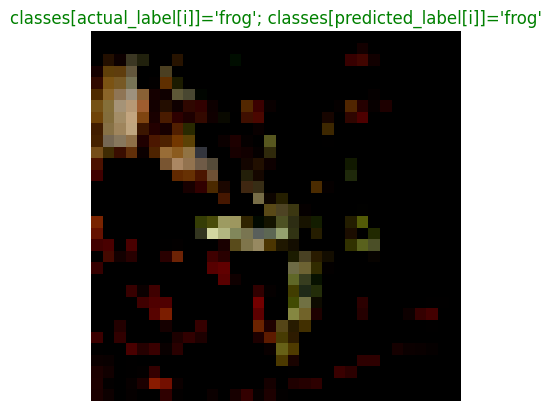

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


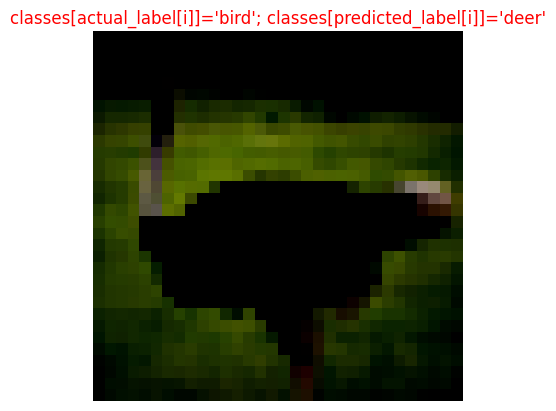

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


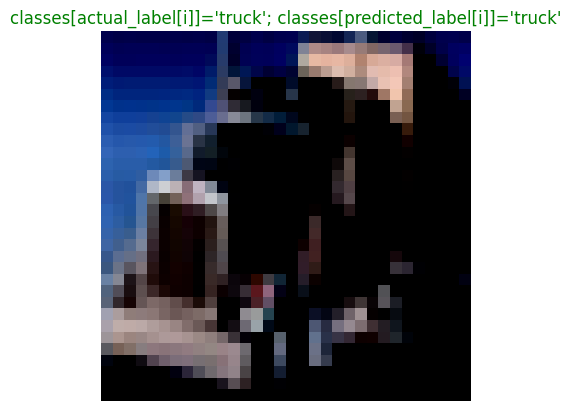

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


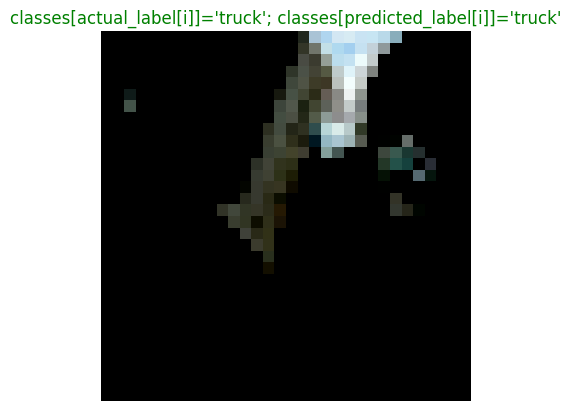

In [17]:
visualize_model_predictions()